<i>Alunos: Lara Destefani e Lucas Borges Pacheco</i>

### **Modelagem de dispersão atmosférica**



**Bibliotecas utilizadas no estudo**

In [1]:
import os
import numpy
import pandas
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from windrose import WindroseAxes
from siphon.simplewebservice.wyoming import WyomingUpperAir

warnings.filterwarnings('ignore')

**Coeficientes de dispersão**

Os coeficientes de dispersão são parâmetros fundamentais na modelagem da dispersão de poluentes atmosféricos, permitindo prever a concentração espacial dos poluentes nas direções horizontal e vertical a partir de uma fonte de emissão.
- Coeficiente σy: Representa a dispersão horizontal lateralmente ao longo da direção do vento.
- Coeficiente σz: Representa a dispersão vertical, sendo afetado pela altura da camada limite.

Esses coeficientes de dispersão são derivados de medições empíricas e variam conforme as condições meteorológicas, a topografia e a natureza dos poluentes envolvidos. No presente estudo, aplicaremos a classificação de estabilidade atmosférica de Pasquill para categorizar as condições de estabilidade da atmosfera e, consequentemente, estimar os coeficientes de dispersão vertical e horizontal em relação à distância da fonte emissora. A classificação de Pasquill é utilizada em modelos para prever a concentração de poluentes em diferentes condições atmosféricas e para diferentes ambientes, urbanos ou rurais.

| Classe de estabilidade | Descrição |
| --- | --- |
| A | Extremamente instável |
| B | Moderadamente instável |
| C | Levemente instável |
| D | Atmosfera neutra |
| E | Levemente estável |
| F | Moderadamente estável |

In [ ]:
def pasquill(ambiente,classe,x):
    if ambiente == 'Urbano':
        if classe in ['A','B']:
            sigmaY = 0.32*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.24*x*(1+0.001*x)**(0.5)

        elif classe == 'C':
            sigmaY = 0.22*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.20*x
        
        elif classe == 'D':
            sigmaY = 0.16*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.14*x*(1+0.0003*x)**(-0.5)

        elif classe in ['E','F']:
            sigmaY = 0.11*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.08*x*(1+0.0015*x)**(-0.5)
        
        print('A classe não existe!')

    elif ambiente == 'Rural':
        if classe == 'A':
            sigmaY = 0.22*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.20*x

        elif classe == 'B':
            sigmaY = 0.16*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.12*x

        elif classe == 'C':
            sigmaY = 0.11*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.08*x*(1+0.0002*x)**(-0.5)

        elif classe == 'D':
            sigmaY = 0.08*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.06*x*(1+0.0015*x)**(-0.5)

        elif classe == 'E':
            sigmaY = 0.06*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.03*x*(1+0.0003*x)**(-1)

        elif classe == 'F':
            sigmaY = 0.04*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.016*x*(1+0.0003*x)**(-1)

        print('A classe não existe!')
        
    else:
        print('O ambiente não se enquadra em urbano ou rural')

    return sigmaY, sigmaZ

**Estimativa de sobrelevação**

A altura efetiva da pluma de uma chaminé (H) refere-se à altura total em que os poluentes são liberados na atmosfera. Esta altura considera tanto a altura física da chaminé (h) quanto a elevação adicional causada pela velocidade e temperatura dos gases emitidos (Δh). A partir dessa altura, a pluma começa a se dispersar.

***H = h + Δh***

O cálculo da altura de sobrelevação da pluma pode ser realizado utilizando diferentes modelos, dependendo das condições específicas de emissão e do ambiente. Neste estudo, foram empregados três métodos distintos, levando em conta o efeito tip-downwash.

*Método de Davidson-Bryant*

In [ ]:
def davidsonBryant(d,Vs,u,deltaT,Ts):
    deltaH = d*((Vs/u)**(1,4))*(1+(deltaT/Ts))
    return deltaH

*Método de Holland*

In [ ]:
#Considera-se aumento e redução da altura para as diferentes condições de estabilidade atmosférica de Pasquill.
def holland(classe, d,Vs,u,deltaT,Ts,p):
    deltaH = (d*Vs/u)*(1,5+2,68*(10**(-3))*p*deltaT*d/Ts)

    #Condições instáveis
    if classe in ['A','B','C']: 
        deltaH = 1,15*deltaH

    #Condições estáveis
    elif classe in ['E','F']:
        deltaH = 0,85*deltaH

    #Condições neutras
    elif classe == 'D':
        deltaH = deltaH

    return deltaH

*Método de Briggs*

In [ ]:
def briggs(classe, d,Vs,u,deltaT,Ts,p):

**Efeito Tip-Downwash**

O efeito tip-downwash ocorre quando o fluxo de ar quente dos gases emitidos pela chaminé entra em contato com o ar ambiente mais frio e estável ao redor, resultando em turbulência na ponta da estrutura. Essa turbulência pode induzir um movimento descendente do ar próximo à extremidade da chaminé, direcionando a pluma em direção ao solo. Isso reduz a altura efetiva da emissão e tem um impacto significativo na dispersão dos poluentes na atmosfera.

Quando a velocidade dos gases emitidos é igual ou superior a 1,5 vezes a velocidade do vento, o efeito tip-downwash geralmente não é relevante. No entanto, se a velocidade de saída for menor, uma altura de chaminé reduzida (h) pode ser calculada usando a equação abaixo.

In [ ]:
def tipDownwash(Vs,u,h,d,Ts,deltaT):
    if Vs > 1.5*u:
        deltaH = davidsonBryant(d,Vs,u,deltaT,Ts)  #Variar método de cálculo
        H = deltaH + h
        print('A pluma subiu!')
    else:
        h = h + 2*d*((Vs/u)-1.5)
        H = deltaH + h
        print('A pluma caiu!')

    return H

----

**Modelo Gaussiano**

O modelo Guaissiano é um modelo de dispersão atmosférica em que a concentração dos poluentes segue uma distribuição normal tanto na direção horizontal quanto na vertical. A função do modelo Gaussiano para a concentração de poluentes em um determinado ponto no espaço a partir de um fonte de emissão é expressa pela equação abaixo

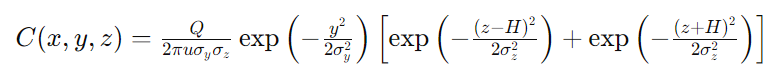

Q: taxa de emissão de poluentes (massa por unidade de tempo)

u: velocidade média do vento na direção x.

H: altura da fonte de emissão

h: altura da chaminé

deltaH = altura da fonte de emissão 0 altura da chaminé


*h*: Altura geométrica da chaminé (m)

*Δh*: Altura de sobrelevação da pluma (m)

*H*: Altura total efetiva (m)

*d*: Diâmetro interno da chaminé (m)

*Vs*: Velocidade do efluente na saída da chaminé (m/s)

*u*: Velocidade média do vento, medida ou calculada na altura da chaminé (m/s)

*ΔT*: Temperatura do gás na chaminé menos a temperatura ambiente (K)

*Ts*: Temperatura do gás na saída da chaminé (K)

*p*: Presão atmosférica (mb)

In [ ]:
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H):
    term1 = qs/(2*numpy.pi*sigmaY*sigmaZ*u)
    term2 = numpy.exp((-(y)**2)/(2*(sigmaY)**2))
    term3 = numpy.exp((-(z-H)**2)/(2*(sigmaZ)**2)) + numpy.exp((-(z+H)**2)/(2*(sigmaZ)**2))
    result = term1*term2*term3
    return result*(10**6)

In [ ]:
x = numpy.linspace(-100,1000,500)
y = numpy.linspace(-100,1000,500)
xx,yy = numpy.meshgrid(x,y)

In [ ]:
qs = 100 #g/s
u = 10 #m/s
y = 0 #direção do vento
z = 1.5 #m
hg = 150 #m
sigmaY = 10 #m
sigmaZ = 15 #m
classe = 'A'
type = 'urbano'
d = 1 #m
vs = 15 #m/s
Ts = 300 #K
Tamb = 293 #K

In [ ]:
sigmaY, sigmaZ = dispersion(xx,classe,type)
deltaH = height_effectiv(d,vs,u,Ts,Tamb)
results = modeloGaussiano(qs,sigmaY,sigmaZ,u,yy,z,hef)
results

**Simulações**

Realizar simulações com o script criado, utilizando diferentes classes de estabilidade, velocidades do vento, alturas de chaminé. Considere a taxa de emissão que você estimou na primeira atividade. Encontre a altura de chaminé necessária para que as concentrações não violem os padrões da Resolução CONAMA 491.


#Chamar funções no codigo para varias simulações
#Variar as funções de sobreelvação da plu,a
#Variar os dados de entrada do pasquil
#variar blabla

Faça figuras e discuta os resultados.

*1. Primeira simulação*

*2.Segunda simulação*

*3. Terceira simulação*